Sample of the dataset:
   document_id  expert1  expert2  expert3
0            1        4        4        5
1            2        2        2        2
2            3        5        4        5
3            4        2        2        2
4            5        3        4        2
5            6        5        5        4
6            7        4        3        4
7            8        5        4        5
8            9        4        4        1
9           10        5        2        5

Intraclass Correlation Results:
ICC(2,1) - Single Rater: 0.579
ICC(2,k) - Average of 3 Raters: 0.805
F-value: 5.071, p-value: 0.00000


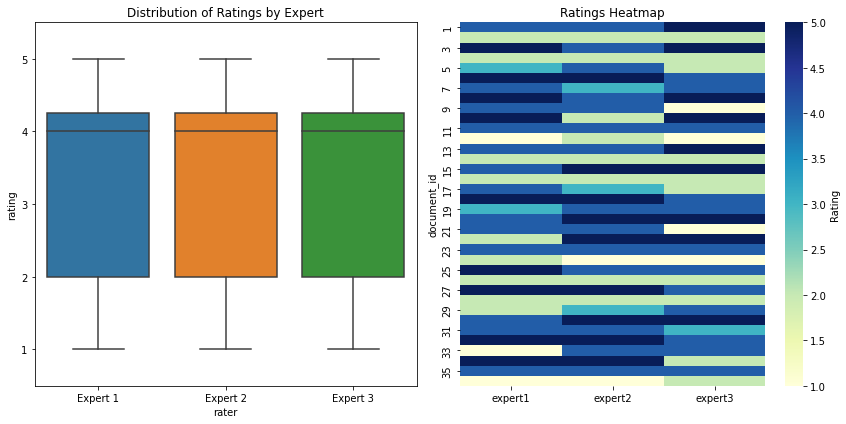


ICC Interpretation:
ICC(2,1) (Two-Way Random Effects, Absolute Agreement, Single Rater): 0.579
Moderate reliability: 0.5 ≤ ICC < 0.75

Correlation between raters:
          expert1   expert2   expert3
expert1  1.000000  0.665688  0.492344
expert2  0.665688  1.000000  0.586157
expert3  0.492344  0.586157  1.000000


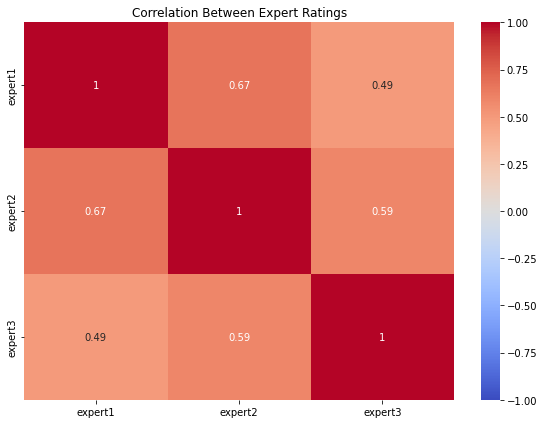

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df_part1 = pd.read_csv('Part1_responses.csv')
df_part2 = pd.read_csv('Part2_responses.csv')
df_part3 = pd.read_csv('Part3_responses.csv')


df_part1.head(2).T

def organize_df(df_p):
    df_p = df_p.drop(df_p.columns[4], axis=1)
    df_p = df_p.drop(df_p.columns[6], axis=1)#7
    df_p = df_p.drop(df_p.columns[8], axis=1)#10
    df_p = df_p.drop(df_p.columns[10], axis=1)#13
    df_p = df_p.drop(df_p.columns[12], axis=1)#16
    df_p = df_p.drop(df_p.columns[14], axis=1)#19

    df_p = df_p.drop(df_p.columns[0], axis=1)#drop timestamp
    df_p = df_p.drop(df_p.columns[0], axis=1)#drop mail
    return df_p

df_p1 = organize_df(df_part1)
df_p2 = organize_df(df_part2)
df_p3 = organize_df(df_part3)

def get_lists(df_p):
    res = df_p1.values.tolist()
    expert1 = res[0] #moni
    expert2 = res[1] #kari
    expert3 = res[2] #delfiM
    return expert1, expert2, expert3


P1_ex1, P1_ex2, P1_ex3 = get_lists(df_p1)

P2_ex1, P2_ex2, P2_ex3 = get_lists(df_p2)
P3_ex1, P3_ex2, P3_ex3 = get_lists(df_p3)

teacher_moni  = P1_ex1 + P2_ex2 + P3_ex3
teacher_kari  = P1_ex2 + P2_ex1 + P3_ex1
teacher_delfi = P1_ex3 + P2_ex3 + P3_ex2

data = {
    'document_id': range(1, 37),
    'expert1': teacher_moni,
    'expert2': teacher_kari,
    'expert3': teacher_delfi
}
df = pd.DataFrame(data)
    
# List of rater columns
rater_columns = ['expert1', 'expert2', 'expert3']

# Display the first few rows
print("Sample of the dataset:")
print(df.head(10))

# Function to calculate ICC using NumPy and SciPy
def calculate_icc(ratings):
    """
    Calculate the Intraclass Correlation Coefficient (ICC) for reliability assessment.
    This implements ICC(2,1) and ICC(2,k) (Two-way random effects, absolute agreement)
    
    Parameters:
    ratings : numpy.ndarray
        A matrix of ratings where rows are subjects and columns are raters
        
    Returns:
    dict containing ICC values and related statistics
    """
    n_subjects, n_raters = ratings.shape
    
    # Calculate grand mean
    grand_mean = np.mean(ratings)
    
    # Calculate subject means
    subject_means = np.mean(ratings, axis=1)
    
    # Calculate rater means
    rater_means = np.mean(ratings, axis=0)
    
    # Calculate total sum of squares
    SS_total = np.sum((ratings - grand_mean) ** 2)
    
    # Calculate between subjects sum of squares
    SS_subjects = n_raters * np.sum((subject_means - grand_mean) ** 2)
    
    # Calculate between raters sum of squares
    SS_raters = n_subjects * np.sum((rater_means - grand_mean) ** 2)
    
    # Calculate residual sum of squares
    SS_residual = SS_total - SS_subjects - SS_raters
    
    # Calculate mean squares
    MS_subjects = SS_subjects / (n_subjects - 1)
    MS_raters = SS_raters / (n_raters - 1)
    MS_residual = SS_residual / ((n_subjects - 1) * (n_raters - 1))
    
    # Calculate ICC(2,1) - Single measure ICC
    icc_single = (MS_subjects - MS_residual) / (
        MS_subjects + (n_raters - 1) * MS_residual + (n_raters / n_subjects) * (MS_raters - MS_residual)
    )
    
    # Calculate ICC(2,k) - Average measure ICC
    icc_average = (MS_subjects - MS_residual) / (
        MS_subjects + (MS_raters - MS_residual) / n_subjects
    )
    
    # Basic F-test for ICC significance
    F = MS_subjects / MS_residual
    p_value = 1 - stats.f.cdf(F, n_subjects - 1, (n_subjects - 1) * (n_raters - 1))
    
    return {
        'ICC_single': icc_single,
        'ICC_average': icc_average,
        'F_value': F,
        'p_value': p_value,
        'n_subjects': n_subjects,
        'n_raters': n_raters
    }

# Calculate ICC using our function
ratings_array = df[rater_columns].values
icc_results = calculate_icc(ratings_array)

# Display results
print("\nIntraclass Correlation Results:")
print(f"ICC(2,1) - Single Rater: {icc_results['ICC_single']:.3f}")
print(f"ICC(2,k) - Average of {icc_results['n_raters']} Raters: {icc_results['ICC_average']:.3f}")
print(f"F-value: {icc_results['F_value']:.3f}, p-value: {icc_results['p_value']:.5f}")

# Visualize ratings distribution
plt.figure(figsize=(12, 6))

# Plot 1: Distribution of ratings by expert
plt.subplot(1, 2, 1)
df_long = pd.melt(df, id_vars=['document_id'], value_vars=rater_columns, 
                  var_name='rater', value_name='rating')
sns.boxplot(x='rater', y='rating', data=df_long)
plt.title('Distribution of Ratings by Expert')
plt.ylim(0.5, 5.5)
plt.xticks([0, 1, 2], ['Expert 1', 'Expert 2', 'Expert 3'])  # More readable labels

# Plot 2: Heatmap of ratings
plt.subplot(1, 2, 2)
heatmap_data = df[rater_columns].copy()
heatmap_data.index = df['document_id']  # Set document_id as index for better labeling
sns.heatmap(heatmap_data, cmap='YlGnBu', cbar_kws={'label': 'Rating'})
plt.title('Ratings Heatmap')

plt.tight_layout()
plt.show()

# Demonstrate the ICC interpretation
print("\nICC Interpretation:")
icc_value = icc_results['ICC_single']
print(f"ICC(2,1) (Two-Way Random Effects, Absolute Agreement, Single Rater): {icc_value:.3f}")

if icc_value < 0.5:
    print("Poor reliability: ICC < 0.5")
elif icc_value < 0.75:
    print("Moderate reliability: 0.5 ≤ ICC < 0.75")
elif icc_value < 0.9:
    print("Good reliability: 0.75 ≤ ICC < 0.9")
else:
    print("Excellent reliability: ICC ≥ 0.9")

# We can also check agreement between specific pairs of raters using correlation
print("\nCorrelation between raters:")
corr_matrix = df[rater_columns].corr()
print(corr_matrix)

# Create a correlation heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Expert Ratings')
plt.tight_layout()
plt.show()